# Modeling and Analysis
*Deval Mehta*

With EDA complete, we move on to our main task: creating data-driven models to make better decisions about bus routes. In addition to the conventional machine learning models we have discussed throughout the course of DSB, we explore **graph-based analysis** here, treating the network of bus stops across eastern Queens as a graph, where the nodes are stops and the edges are connections between stops, based either on established routes or using a distance heuristic. Our goals for modeling are as follows:
- Instantiate and run DBSCAN to check for areas of high and low density, which will be transit hubs and underserved areas
- Model the stop network as a graph, then use PageRank to define transit hubs and underserved areas

DBSCAN and PageRank both proved unfruitful for different reasons. In the case of DBSCAN, finding an adequate value for epsilon proved difficult. PageRank is designed for directed graphs and New York's public transit network is better described as an undirected graph. For these reasons, we opt instead for HDBSCAN, which no longer requires specifying the parameter `eps` and the Louvain method, a greedy algorithm for determining the community structure of a graph.

## Imports and Reading in Data

In [46]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import networkx as nx
import community as clouvain
import glob
import hdbscan
import pickle
import gzip
import json

from collections import Counter
from geopy.distance import geodesic
from itertools import combinations
from tqdm import tqdm

from scipy.spatial import cKDTree
from scipy.stats import pearsonr

from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, root_mean_squared_error
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import SARIMAX

import warnings
warnings.filterwarnings('ignore')

In [3]:
# File Paths
data_directory = "../data/"
static_data_file = f"{data_directory}stops.csv"
geojson_file = f"{data_directory}nyc_by_neighborhood_2020.geojson"
real_time_files_pattern = f"{data_directory}realtime_data_MTA NYCT_*.csv"

In [4]:
# Load Static Data
stops_data = pd.read_csv(static_data_file)
stops_data.rename(
    columns={
        "Route ID": "route_id",
        "Stop ID": "stop_id",
        "Stop Name": "stop_name",
        "Latitude": "stop_lat",
        "Longitude": "stop_lon",
    },
    inplace=True,
)

stops_data["route_id"] = stops_data["route_id"].str.replace('%20', ' ', regex=False)
stops_data["coords"] = stops_data[["stop_lat", "stop_lon"]].apply(tuple, axis=1)

# Convert to GeoDataFrame
stops_gdf = gpd.GeoDataFrame(
    stops_data, geometry=gpd.points_from_xy(stops_data["stop_lon"], stops_data["stop_lat"]), crs="EPSG:4326"
)

# Load Queens Map
nyc_map = gpd.read_file(geojson_file)
queens_map = nyc_map[nyc_map["boroname"].str.contains("Queens", case=False)]

# Spatial join stops and queens_map gdfs to preserve neighborhood information
stops_gdf = stops_gdf.sjoin(queens_map, how="left", predicate="within")
stops_gdf.rename(columns={"neighborhood": "neighborhood_name"}, inplace=True)

In [5]:
# Load Queens Map
nyc_map = gpd.read_file(geojson_file)
queens_map = nyc_map[nyc_map["boroname"].str.contains("Queens", case=False)]

In [6]:
# Function to visualize results
def visualize_clusters(
    df, cluster_col, title, map_data=None, map_color="lightgray",
    map_edgecolor="black", save_path=None
):
    """
    Visualize clusters with transparency and overlay a layer showing all stops.

    Parameters:
    - df: GeoDataFrame containing the clustering results.
    - cluster_col: Column name for cluster/community IDs.
    - title: Title for the plot.
    - map_data: GeoDataFrame for the base map (optional).
    - map_color: Color for the base map (default: light gray).
    - map_edgecolor: Edge color for the base map (default: black).
    - save_path: File path to save the plot (optional).
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot the base map (e.g., Queens neighborhoods)
    if map_data is not None:
        map_data.plot(ax=ax, color=map_color, edgecolor=map_edgecolor, alpha=0.5)
    
    # Plot all stops with a neutral color as a separate layer
    df.plot(ax=ax, color="black", markersize=10, alpha=0.5, label="All Stops")
    
    # Overlay clusters with transparency
    df.plot(
        ax=ax,
        column=cluster_col,
        cmap="tab20b",
        markersize=20,
        alpha=0.7,
        legend=True
    )
    
    # Add title and axis labels
    plt.title(title, fontsize=16)
    plt.xlabel("Longitude", fontsize=12)
    plt.ylabel("Latitude", fontsize=12)
    plt.legend(loc="upper right")
    
    # Save the plot if a save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Plot saved to {save_path}")
    plt.show()

In [7]:
# Load Real-Time Data
real_time_files = glob.glob(real_time_files_pattern)
real_time_data = pd.concat([pd.read_csv(file) for file in real_time_files], ignore_index=True)

# Rename columns for consistency
real_time_data.rename(
    columns={
        "Route ID": "route_id",
        "Vehicle ID": "vehicle_id",
        "Latitude": "vehicle_lat",
        "Longitude": "vehicle_lon",
        "Timestamp": "timestamp",
    },
    inplace=True
)

real_time_data["route_id"] = real_time_data["route_id"].str.strip()

# Assign stop_id to real_time_data using spatial matching
def find_nearest_stop(row, stops_df):
    row_coords = (row["vehicle_lat"], row["vehicle_lon"])
    distances = stops_df["coords"].apply(lambda stop_coords: geodesic(row_coords, stop_coords).meters)
    nearest_stop_idx = distances.idxmin()
    return stops_df.loc[nearest_stop_idx, "stop_id"]

tqdm.pandas(desc="Assigning Stop IDs to Real-Time Data")
real_time_data["stop_id"] = real_time_data.progress_apply(lambda row: find_nearest_stop(row, stops_data), axis=1)

# Ensure timestamp is parsed
real_time_data["timestamp"] = pd.to_datetime(real_time_data["timestamp"])

# Sort by route, vehicle, and timestamp
real_time_data = real_time_data.sort_values(["route_id", "vehicle_id", "timestamp"])

Assigning Stop IDs to Real-Time Data: 100%|████████████████████████████████████| 60175/60175 [3:22:35<00:00,  4.95it/s]


In [8]:
# Extract coordinates from stops_gdf
stop_coords = np.radians(stops_gdf[["stop_lat", "stop_lon"]].values)

# Extract vehicle coordinates from real-time data
real_time_coords = np.radians(real_time_data[["vehicle_lat", "vehicle_lon"]].values)

# Build a KDTree for efficient nearest neighbor search
stop_tree = cKDTree(stop_coords)

# Query the nearest stop for each real-time data point
distances, indices = stop_tree.query(real_time_coords)

# Assign the nearest stop_id to each real-time record
real_time_data["nearest_stop_id"] = stops_gdf.iloc[indices]["stop_id"].values
real_time_data["distance_to_stop"] = distances * 6371  # Convert radians to kilometers

## HDBSCAN

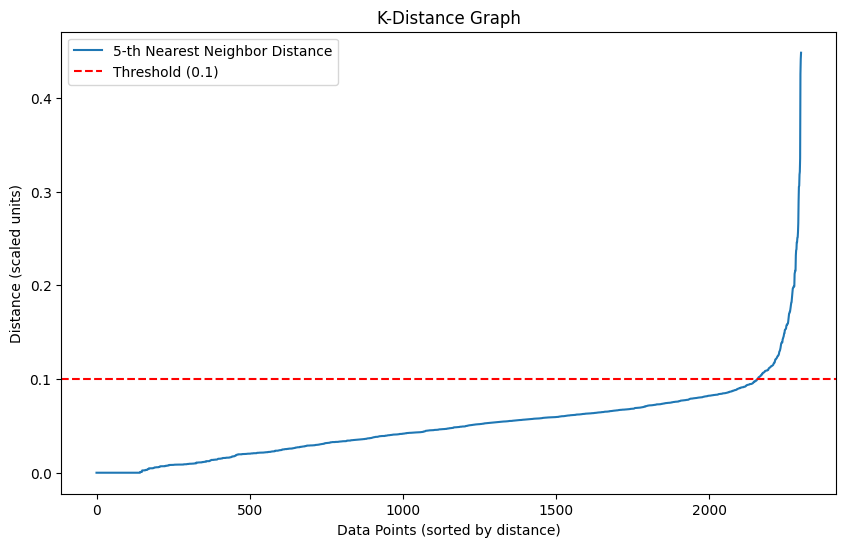

In [9]:
# Extract and scale coordinates for clustering
spatial_scaler = StandardScaler()
scaled_coords = spatial_scaler.fit_transform(stops_gdf[["stop_lat", "stop_lon"]].values)

# Compute k-nearest neighbors
k = 5  # Choose a small k for local density estimation
nbrs = NearestNeighbors(n_neighbors=k).fit(scaled_coords)
distances, indices = nbrs.kneighbors(scaled_coords)

# Plot k-distance graph
distances = np.sort(distances[:, -1])  # k-th nearest neighbor distances
plt.figure(figsize=(10, 6))
plt.plot(distances, label=f"{k}-th Nearest Neighbor Distance")
plt.title("K-Distance Graph")
plt.xlabel("Data Points (sorted by distance)")
plt.ylabel("Distance (scaled units)")
plt.axhline(y=0.1, color="r", linestyle="--", label="Threshold (0.1)")
plt.legend()
plt.show()

In [10]:
# Define grid search ranges
min_cluster_size_range = [50, 100, 150]  # Larger clusters
min_samples_range = [20, 30, 40]         # Tighten density requirements

# Grid search for HDBSCAN parameters
best_model = None
best_score = float("-inf")

print("Performing grid search over HDBSCAN parameters...")
for min_cluster_size in min_cluster_size_range:
    for min_samples in min_samples_range:
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            metric="haversine"
        )
        labels = clusterer.fit_predict(scaled_coords)
        
        # Compute Silhouette Score for validation
        if len(set(labels)) > 1:
            score = silhouette_score(scaled_coords, labels, metric="euclidean")
            print(f"min_cluster_size={min_cluster_size}, min_samples={min_samples}, Silhouette Score={score:.3f}")
            if score > best_score:
                best_score = score
                best_model = clusterer

# Assign best HDBSCAN results
stops_gdf["hdbscan_cluster"] = best_model.labels_

Performing grid search over HDBSCAN parameters...
min_cluster_size=50, min_samples=20, Silhouette Score=-0.084
min_cluster_size=50, min_samples=30, Silhouette Score=-0.058
min_cluster_size=50, min_samples=40, Silhouette Score=-0.085
min_cluster_size=100, min_samples=20, Silhouette Score=-0.038
min_cluster_size=100, min_samples=30, Silhouette Score=0.114
min_cluster_size=100, min_samples=40, Silhouette Score=0.243
min_cluster_size=150, min_samples=20, Silhouette Score=0.101
min_cluster_size=150, min_samples=30, Silhouette Score=0.248
min_cluster_size=150, min_samples=40, Silhouette Score=0.243


Plot saved to ../images/hdbscan_clusters_map.png


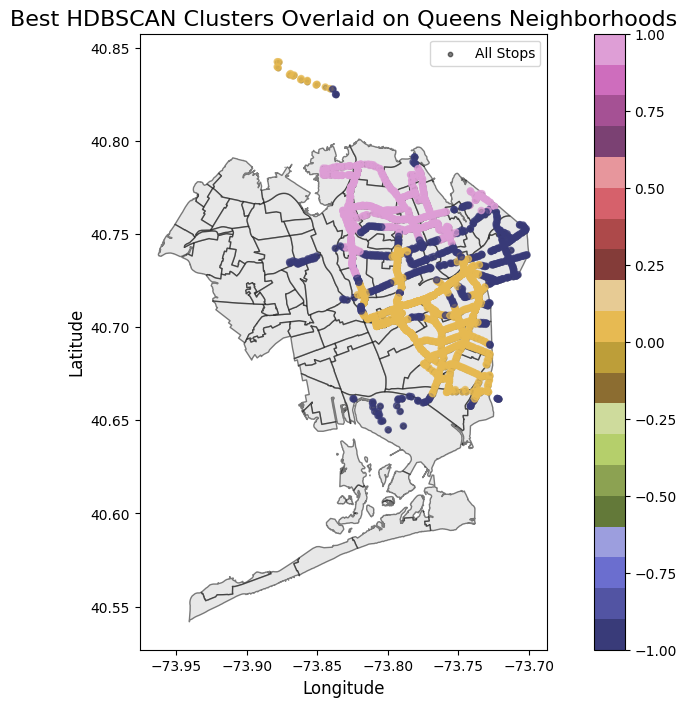

In [11]:
# Visualize HDBSCAN clusters and save the plot
visualize_clusters(
    stops_gdf,
    cluster_col="hdbscan_cluster",
    title="Best HDBSCAN Clusters Overlaid on Queens Neighborhoods",
    map_data=queens_map,
    save_path="../images/hdbscan_clusters_map.png"
)

## Louvain Method

In [12]:
# Add edges with weights from real-time data
edges = []
for route_id in real_time_data["route_id"].unique():
    route_data = real_time_data[real_time_data["route_id"] == route_id]
    for vehicle_id in route_data["vehicle_id"].unique():
        vehicle_data = route_data[route_data["vehicle_id"] == vehicle_id]
        stops = vehicle_data["nearest_stop_id"].tolist()
        for i in range(len(stops) - 1):
            stop1, stop2 = stops[i], stops[i + 1]
            if stop1 != stop2:  # Avoid self-loops
                coord1 = stops_gdf.loc[stops_gdf["stop_id"] == stop1, "coords"].values[0]
                coord2 = stops_gdf.loc[stops_gdf["stop_id"] == stop2, "coords"].values[0]
                distance = geodesic(coord1, coord2).kilometers
                edges.append((stop1, stop2, {"weight": 1 / distance}))  # Weight by inverse distance

# Create Graph with Real-Time Data Edges
G = nx.Graph()

# Add nodes
G.add_nodes_from(stops_gdf["stop_id"])

# Add edges from real-time data
G.add_edges_from(edges)

# Filter edges by weight (e.g., distance or frequency)
threshold = 0.1  # Adjust based on your analysis
filtered_edges = [(u, v, d) for u, v, d in G.edges(data=True) if d["weight"] > threshold]
# Sort real-time data for each vehicle and route
real_time_data = real_time_data.sort_values(["route_id", "vehicle_id", "timestamp"])

Plot saved to ../images/louvain_communities_map.png


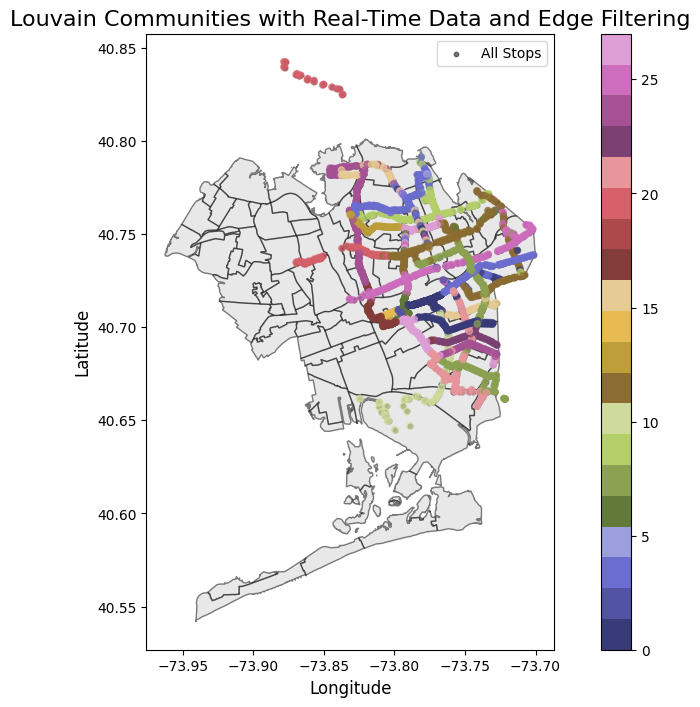

Louvain clustering with real-time data complete. Results saved.


In [50]:
# Filter edges by weight
threshold = 0.1  # Adjust based on your analysis
filtered_edges = [(u, v, d) for u, v, d in edges if d["weight"] > threshold]

# Create graph with filtered edges
G = nx.Graph()
G.add_edges_from(filtered_edges)

# Run Louvain Method with higher resolution
partition = clouvain.best_partition(G, weight="weight", resolution=2.0)  # Higher resolution for finer clusters
stops_gdf["louvain_community"] = stops_gdf["stop_id"].map(partition)

# Visualize Louvain communities
visualize_clusters(
    stops_gdf,
    cluster_col="louvain_community",
    title="Louvain Communities with Real-Time Data and Edge Filtering",
    map_data=queens_map,
    save_path = "../images/louvain_communities_map.png"
)
plt.show()

# Save Louvain results
stops_gdf.to_csv(f"{data_directory}louvain_with_realtime.csv", index=False)
print("Louvain clustering with real-time data complete. Results saved.")

In [14]:
# Save Louvain results
stops_gdf.to_csv(f"{data_directory}louvain_communities_realtime.csv", index=False)
print("Louvain community detection with real-time edges complete. Results saved.")

Louvain community detection with real-time edges complete. Results saved.


In [15]:
# Modularity
modularity_score = clouvain.modularity(partition, G, weight="weight")
print(f"Modularity Score: {modularity_score:.4f}")

# Community Size Distribution
community_sizes = Counter(partition.values())
print("Community Size Distribution:", community_sizes)

Modularity Score: 0.7570
Community Size Distribution: Counter({0: 142, 16: 116, 12: 112, 8: 106, 20: 105, 4: 80, 3: 76, 7: 76, 17: 74, 1: 72, 11: 65, 10: 64, 5: 57, 21: 51, 13: 48, 14: 48, 25: 47, 22: 46, 26: 45, 23: 42, 15: 39, 19: 37, 24: 33, 2: 31, 6: 23, 9: 3, 18: 2})


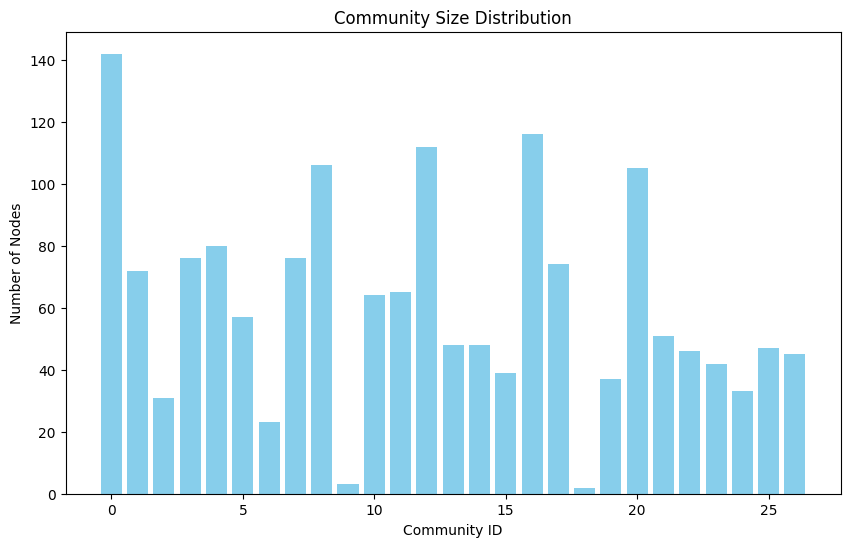

In [16]:
# Plot Community Size Distribution
plt.figure(figsize=(10, 6))
plt.bar(community_sizes.keys(), community_sizes.values(), color="skyblue")
plt.title("Community Size Distribution")
plt.xlabel("Community ID")
plt.ylabel("Number of Nodes")
plt.show()

In [17]:
# Coverage
def compute_coverage(G, partition):
    intra_edges = sum(1 for edge in G.edges if partition[edge[0]] == partition[edge[1]])
    total_edges = G.number_of_edges()
    return intra_edges / total_edges

coverage = compute_coverage(G, partition)
print(f"Coverage: {coverage:.4f}")

Coverage: 0.3987


## Time Series Analysis

In [18]:
# 1. Data Preparation
route_ids = stops_gdf["route_id"].unique()
all_data = []
for route_id in tqdm(route_ids, desc="Processing Routes"):
    df = real_time_data[real_time_data["route_id"] == route_id]
    df["Route"] = route_id
    all_data.append(df)

# Combine all routes
combined_data = pd.concat(all_data)
combined_data.set_index("timestamp", inplace=True)

# Resample data to hourly frequency
hourly_data = combined_data.resample("H").count()
hourly_data.reset_index(inplace=True)

Processing Routes: 100%|██████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 236.83it/s]


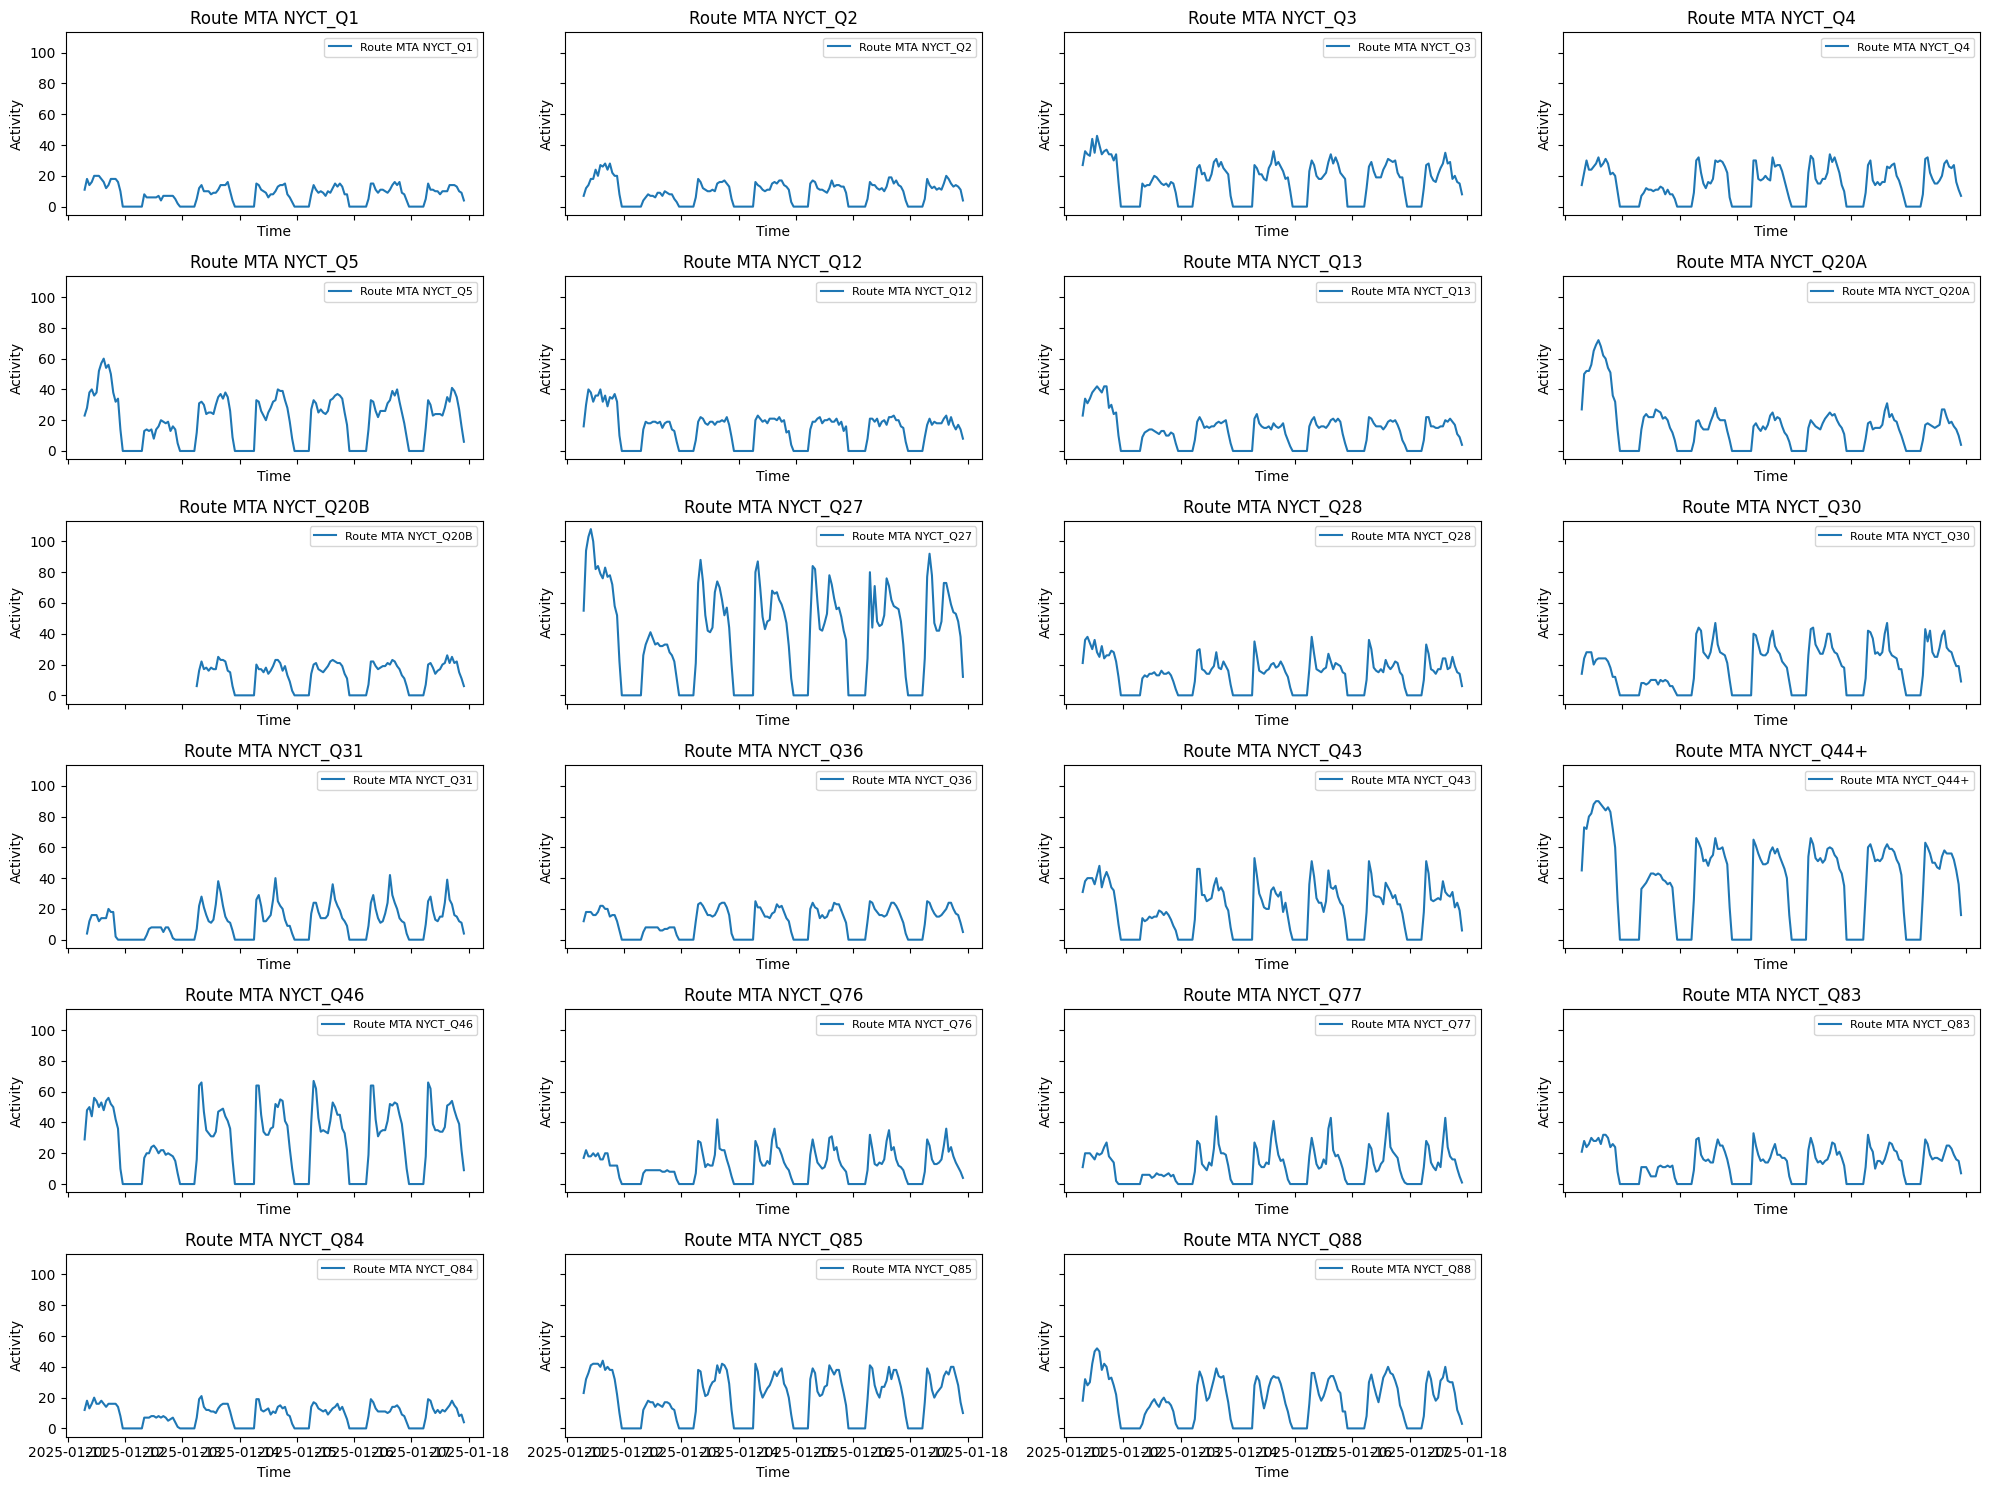

In [19]:
# 2. Exploratory Analysis
# Unique routes and grid dimensions
unique_routes = combined_data["Route"].unique()
num_routes = len(unique_routes)
grid_rows = 6  # Define a fixed grid with 6 rows
grid_cols = 4  # Define a fixed grid with 4 columns

# Create subplots
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(20, 15), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten axes for easy indexing

# Plot each route on a separate subplot
for idx, route_id in enumerate(unique_routes):
    ax = axes[idx]
    route_data = combined_data[combined_data["Route"] == route_id]

    if route_data.empty:
        ax.text(0.5, 0.5, f"No data for {route_id}", ha="center", va="center", fontsize=10)
        ax.set_title(f"Route {route_id}")
        ax.axis("off")
        continue

    # Resample hourly activity for the route
    hourly_activity = route_data.resample("H").size()

    # Plot data
    ax.plot(hourly_activity.index, hourly_activity.values, label=f"Route {route_id}", color="tab:blue")
    ax.set_title(f"Route {route_id}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Activity")
    ax.legend(fontsize=8)

# Turn off unused subplots
for idx in range(len(unique_routes), len(axes)):
    axes[idx].axis("off")

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("../images/routes_activity_trends_grid.png", dpi=300)
plt.show()

In [20]:
combined_data.head()

route_id     vehicle_id  vehicle_lat  \
timestamp                                                             
2025-01-17 16:14:15.934460  MTA NYCT_Q1  MTA NYCT_8000    40.720086   
2025-01-17 16:44:21.733455  MTA NYCT_Q1  MTA NYCT_8000    40.728656   
2025-01-17 17:14:27.681662  MTA NYCT_Q1  MTA NYCT_8000    40.707910   
2025-01-17 17:44:33.562827  MTA NYCT_Q1  MTA NYCT_8000    40.725585   
2025-01-17 18:14:39.930786  MTA NYCT_Q1  MTA NYCT_8000    40.722191   

                            vehicle_lon     stop_id nearest_stop_id  \
timestamp                                                             
2025-01-17 16:14:15.934460   -73.761766  MTA_500017      MTA_500017   
2025-01-17 16:44:21.733455   -73.743449  MTA_500027      MTA_500027   
2025-01-17 17:14:27.681662   -73.795797  MTA_504421      MTA_504421   
2025-01-17 17:44:33.562827   -73.740205  MTA_500029      MTA_500029   
2025-01-17 18:14:39.930786   -73.757774  MTA_500073      MTA_500073   

                            distance_to_stop        Route  
timestamp                                                  
2025-01-17 16:14:15.934460          0.037009  MTA NYCT_Q1  
2025-01-17 16:44:21.733455          0.080143  MTA NYCT_Q1  
2025-01-17 17:14:27.681662          0.002813  MTA NYCT_Q1  
2025-01-17 17:44:33.562827          0.021109  MTA NYCT_Q1  
2025-01-17 18:14:39.930786          0.029424  MTA NYCT_Q1

Fitting STL Decomposition:   0%|                                                                 | 0/1 [00:00<?, ?it/s]


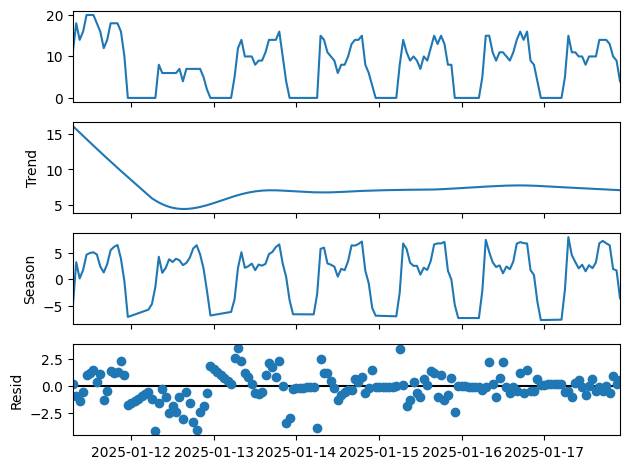

In [22]:
# 3. Seasonality and Trend Analysis
route_id = route_ids[0]  # Analyze the first route for demonstration
route_data = combined_data[combined_data["Route"] == route_id].resample("H").size()
stl = STL(route_data, period=24)
with tqdm(desc="Fitting STL Decomposition", total=1):
    result = stl.fit()
result.plot()
plt.show()

In [23]:
# Metrics for Seasonality and Trend Analysis
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Pearson correlation between trend and observed data
correlation_trend, _ = pearsonr(trend[~np.isnan(trend)], route_data[~np.isnan(trend)])
print(f"Correlation between trend and observed data: {correlation_trend:.2f}")

Correlation between trend and observed data: 0.46


In [24]:
# 4. Clustering Temporal Patterns
activity_matrix = combined_data.pivot_table(
    index=combined_data.index.hour,  # Hour of day
    columns="Route",
    values="vehicle_id",
    aggfunc="count",
    fill_value=0
)

scaler = StandardScaler()
normalized_data = scaler.fit_transform(activity_matrix.T)

# Apply HDBSCAN for clustering temporal patterns
hdbscan_temporal_model = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1, metric="euclidean")
with tqdm(desc="Clustering Temporal Patterns with HDBSCAN", total=1):
    temporal_labels = hdbscan_temporal_model.fit_predict(normalized_data)

# Handle cases with all noise
if len(set(temporal_labels)) <= 1:  # Only -1 or no valid clusters
    print("All points labeled as noise. Adjusting HDBSCAN parameters or re-checking data may be needed.")
else:
    # Store clustering labels
    route_labels = pd.Series(temporal_labels, index=activity_matrix.columns, name="Cluster")
    print("Route Clustering Labels with HDBSCAN:")
    print(route_labels)

    # Silhouette Score for Clustering
    valid_indices = temporal_labels != -1
    silhouette_avg_hdbscan = silhouette_score(normalized_data[valid_indices], temporal_labels[valid_indices])
    print(f"Silhouette Score for Temporal Clustering with HDBSCAN: {silhouette_avg_hdbscan:.2f}")

Clustering Temporal Patterns with HDBSCAN:   0%|                                                 | 0/1 [00:00<?, ?it/s]

Route Clustering Labels with HDBSCAN:
Route
MTA NYCT_Q1      1
MTA NYCT_Q12     1
MTA NYCT_Q13     1
MTA NYCT_Q2      1
MTA NYCT_Q20A    1
MTA NYCT_Q20B    1
MTA NYCT_Q27     0
MTA NYCT_Q28     1
MTA NYCT_Q3      1
MTA NYCT_Q30     1
MTA NYCT_Q31     1
MTA NYCT_Q36     1
MTA NYCT_Q4      1
MTA NYCT_Q43     1
MTA NYCT_Q44+    0
MTA NYCT_Q46     1
MTA NYCT_Q5      1
MTA NYCT_Q76     1
MTA NYCT_Q77     1
MTA NYCT_Q83     1
MTA NYCT_Q84     1
MTA NYCT_Q85     1
MTA NYCT_Q88     1
Name: Cluster, dtype: int64
Silhouette Score for Temporal Clustering with HDBSCAN: 0.71


Plot saved to ../images/hdbscan_clusters_map.png


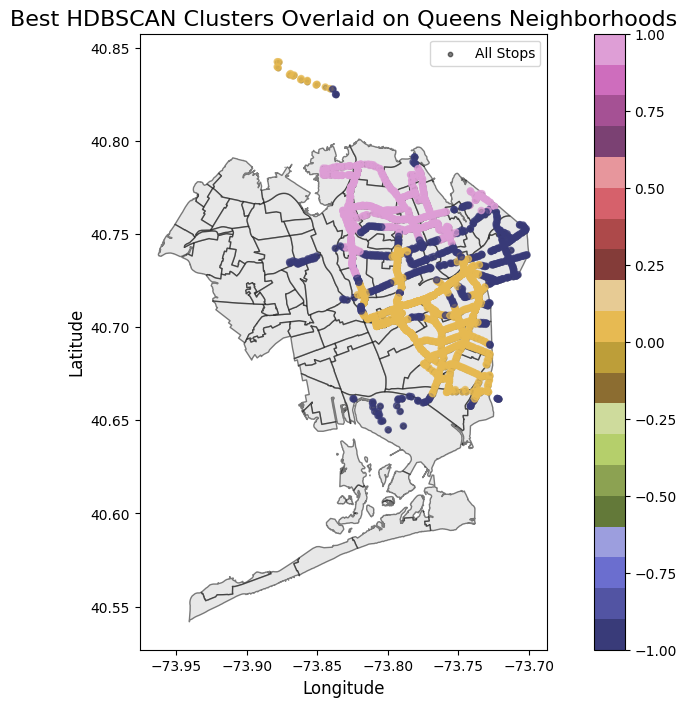

In [25]:
# Visualize HDBSCAN clusters
visualize_clusters(
    stops_gdf,
    cluster_col="hdbscan_cluster",
    title="Best HDBSCAN Clusters Overlaid on Queens Neighborhoods",
    map_data=queens_map,
    save_path="../images/hdbscan_clusters_map.png"
)

In [26]:
# 5. Forecasting with SARIMA
route_data = combined_data[combined_data["Route"] == route_id].resample("H").size()

# Define SARIMA model with daily seasonality
model = SARIMAX(route_data, order=(2, 1, 2), seasonal_order=(1, 1, 1, 24))
with tqdm(desc="Fitting SARIMA Model", total=1):
    fitted_model = model.fit()

forecast = fitted_model.forecast(steps=24)

Fitting SARIMA Model:   0%|                                                                      | 0/1 [00:05<?, ?it/s]


In [27]:
# Calculate Mean Squared Error (MSE) for validation
observed = route_data[-24:]  # Last 24 hours for comparison
rmse = root_mean_squared_error(observed, forecast[:len(observed)])
print(f"Root Mean Squared Error of Forecast: {rmse:.2f}")

Root Mean Squared Error of Forecast: 1.67


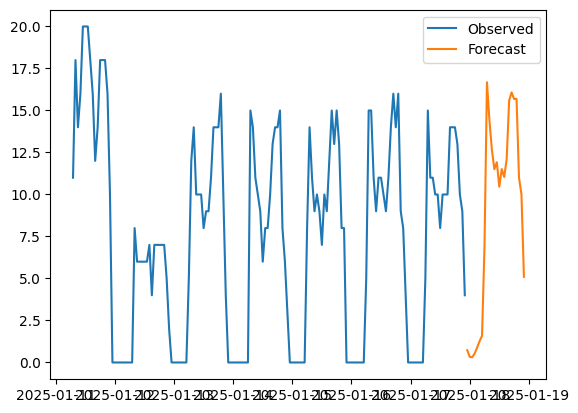

In [28]:
plt.plot(route_data, label="Observed")
plt.plot(forecast, label="Forecast")
plt.legend()
plt.show()

In [29]:
# 6. Temporal Coverage Analysis
real_time_data["Time Gap"] = real_time_data["timestamp"].diff().dt.total_seconds() / 60
with tqdm(desc="Identifying Large Gaps", total=1):
    large_gaps = real_time_data[real_time_data["Time Gap"] > 30]
print(large_gaps)

# Metrics for Coverage Analysis
coverage_percentage = 100 * (1 - large_gaps.shape[0] / real_time_data.shape[0])
print(f"Coverage Percentage: {coverage_percentage:.2f}%")

Identifying Large Gaps:   0%|                                                                    | 0/1 [00:00<?, ?it/s]


           route_id     vehicle_id  vehicle_lat  vehicle_lon  \
1154    MTA NYCT_Q1  MTA NYCT_8000    40.728656   -73.743449   
1163    MTA NYCT_Q1  MTA NYCT_8000    40.707910   -73.795797   
1164    MTA NYCT_Q1  MTA NYCT_8000    40.725585   -73.740205   
1175    MTA NYCT_Q1  MTA NYCT_8000    40.722191   -73.757774   
1182    MTA NYCT_Q1  MTA NYCT_8000    40.707925   -73.795758   
...             ...            ...          ...          ...   
59254  MTA NYCT_Q88  MTA NYCT_8846    40.740898   -73.758047   
59266  MTA NYCT_Q88  MTA NYCT_8846    40.717932   -73.736359   
59285  MTA NYCT_Q88  MTA NYCT_8846    40.738493   -73.799801   
59297  MTA NYCT_Q88  MTA NYCT_8846    40.733955   -73.864459   
59311  MTA NYCT_Q88  MTA NYCT_8846    40.729666   -73.744539   

                       timestamp     stop_id nearest_stop_id  \
1154  2025-01-17 16:44:21.733455  MTA_500027      MTA_500027   
1163  2025-01-17 17:14:27.681662  MTA_504421      MTA_504421   
1164  2025-01-17 17:44:33.562827  MTA_5

In [30]:
# 7. Comparative Analysis
with tqdm(desc="Comparing Activity-to-Stop Ratios", total=1):
    # Group combined_data by route and count vehicle activity
    activity_counts = combined_data.groupby("Route")[["vehicle_id"]].count()

    # Group stops_gdf by route and count the number of stops
    stop_counts = stops_gdf.groupby("route_id").size()

    # Align indices to a common index
    common_index = activity_counts.index.intersection(stop_counts.index)
    aligned_activity_counts = activity_counts.loc[common_index].astype(float)
    stop_counts = stop_counts.loc[common_index].astype(float)

    # Compute the ratio
    combined_summary = (aligned_activity_counts / stop_counts).fillna(0)

# Debug Outputs
print("\nAligned Activity Counts:")
print(aligned_activity_counts)

print("\nStop Counts:")
print(stop_counts)

print("\nCombined Summary After Division:")
print(combined_summary)

Comparing Activity-to-Stop Ratios:   0%|                                                         | 0/1 [00:00<?, ?it/s]


Aligned Activity Counts:
               vehicle_id
MTA NYCT_Q1        1221.0
MTA NYCT_Q12       2233.0
MTA NYCT_Q13       1992.0
MTA NYCT_Q2        1473.0
MTA NYCT_Q20A      2527.0
MTA NYCT_Q20B      1428.0
MTA NYCT_Q27       6180.0
MTA NYCT_Q28       2163.0
MTA NYCT_Q3        2638.0
MTA NYCT_Q30       2821.0
MTA NYCT_Q31       1767.0
MTA NYCT_Q36       1839.0
MTA NYCT_Q4        2238.0
MTA NYCT_Q43       3101.0
MTA NYCT_Q44+      5977.0
MTA NYCT_Q46       4371.0
MTA NYCT_Q5        3164.0
MTA NYCT_Q76       1829.0
MTA NYCT_Q77       1781.0
MTA NYCT_Q83       2097.0
MTA NYCT_Q84       1349.0
MTA NYCT_Q85       3188.0
MTA NYCT_Q88       2798.0

Stop Counts:
MTA NYCT_Q1       83.0
MTA NYCT_Q12      69.0
MTA NYCT_Q13      93.0
MTA NYCT_Q2       67.0
MTA NYCT_Q20A    119.0
MTA NYCT_Q20B    125.0
MTA NYCT_Q27     153.0
MTA NYCT_Q28      73.0
MTA NYCT_Q3      108.0
MTA NYCT_Q30     110.0
MTA NYCT_Q31     121.0
MTA NYCT_Q36     134.0
MTA NYCT_Q4       70.0
MTA NYCT_Q43      95.0
MTA NYCT_Q44+ 

In [31]:
# Merge route_labels with stops_gdf
louvain_temporal_data = stops_gdf.merge(
    route_labels,
    left_on="route_id",
    right_index=True,
    how="left"
)

# Analyze patterns by Louvain community
community_analysis = louvain_temporal_data.groupby("louvain_community")["Cluster"].value_counts(normalize=True)

print("Community-level temporal clustering proportions:")
print(community_analysis)

Community-level temporal clustering proportions:
louvain_community  Cluster
0.0                1          0.993750
                   0          0.006250
1.0                1          1.000000
2.0                1          1.000000
3.0                1          0.975410
                   0          0.024590
4.0                1          0.637681
                   0          0.362319
5.0                1          1.000000
6.0                1          1.000000
7.0                1          1.000000
8.0                1          0.986667
                   0          0.013333
9.0                1          1.000000
10.0               1          1.000000
11.0               1          1.000000
12.0               1          0.993103
                   0          0.006897
13.0               0          0.836364
                   1          0.163636
14.0               1          0.964286
                   0          0.035714
15.0               1          0.952381
                   0       

In [32]:
# 8. Integration with Louvain
# Assess Service Levels for Louvain Communities

# Merge stops_gdf with real_time_data to include vehicle_id
stops_with_realtime = stops_gdf.merge(
    real_time_data,
    on="route_id",
    how="left",
)

# Merge temporal clusters with Louvain communities
louvain_temporal_data = stops_with_realtime.merge(
    route_labels,
    left_on="route_id",
    right_index=True,
    how="left",
)

In [33]:
# Assess Service Levels for Louvain Communities

# 1. Total Vehicle Activity per Community
vehicle_activity = (
    louvain_temporal_data.groupby("louvain_community")["vehicle_id"].count()
)

# 2. Number of Stops per Community
num_stops = (
    stops_gdf.groupby("louvain_community").size()
)

# 3. Average Temporal Activity per Community
avg_activity = (
    louvain_temporal_data.groupby("louvain_community")["Cluster"]
    .value_counts(normalize=True)
    .groupby(level=0)
    .mean()
)

# Combine metrics into a summary DataFrame
service_summary = pd.DataFrame({
    "Total Vehicle Activity": vehicle_activity,
    "Number of Stops": num_stops,
    "Average Temporal Activity": avg_activity
})

# Calculate additional metrics
service_summary["Activity Per Stop"] = (
    service_summary["Total Vehicle Activity"] / service_summary["Number of Stops"]
)

# Display the summary
print("Louvain Community Service Summary:")
service_summary

Louvain Community Service Summary:


Total Vehicle Activity  Number of Stops  \
louvain_community                                            
0.0                                584454              160   
1.0                                170893               78   
2.0                                 81289               40   
3.0                                285959              122   
4.0                                516998              138   
5.0                                304844              156   
6.0                                101649               46   
7.0                                142926               77   
8.0                                312360              150   
9.0                                  6489                3   
10.0                               202208               67   
11.0                               171470               65   
12.0                               304969              145   
13.0                               301258               55   
14.0                               153200               56   
15.0                                72528               42   
16.0                               450590              140   
17.0                               265428               93   
18.0                                19864                6   
19.0                               190044               55   
20.0                               507695              180   
21.0                               136419               51   
22.0                                84455               47   
23.0                                97732               50   
24.0                                58773               33   
25.0                               281976              109   
26.0                               293977              121   

                   Average Temporal Activity  Activity Per Stop  
louvain_community                                                
0.0                                      0.5        3652.837500  
1.0                                      1.0        2190.935897  
2.0                                      1.0        2032.225000  
3.0                                      0.5        2343.926230  
4.0                                      0.5        3746.362319  
5.0                                      1.0        1954.128205  
6.0                                      1.0        2209.760870  
7.0                                      1.0        1856.181818  
8.0                                      0.5        2082.400000  
9.0                                      1.0        2163.000000  
10.0                                     1.0        3018.029851  
11.0                                     1.0        2638.000000  
12.0                                     0.5        2103.234483  
13.0                                     0.5        5477.418182  
14.0                                     0.5        2735.714286  
15.0                                     0.5        1726.857143  
16.0                                     0.5        3218.500000  
17.0                                     1.0        2854.064516  
18.0                                     0.5        3310.666667  
19.0                                     0.5        3455.345455  
20.0                                     0.5        2820.527778  
21.0                                     0.5        2674.882353  
22.0                                     0.5        1796.914894  
23.0                                     1.0        1954.640000  
24.0                                     1.0        1781.000000  
25.0                                     0.5        2586.935780  
26.0                                     0.5        2429.561983

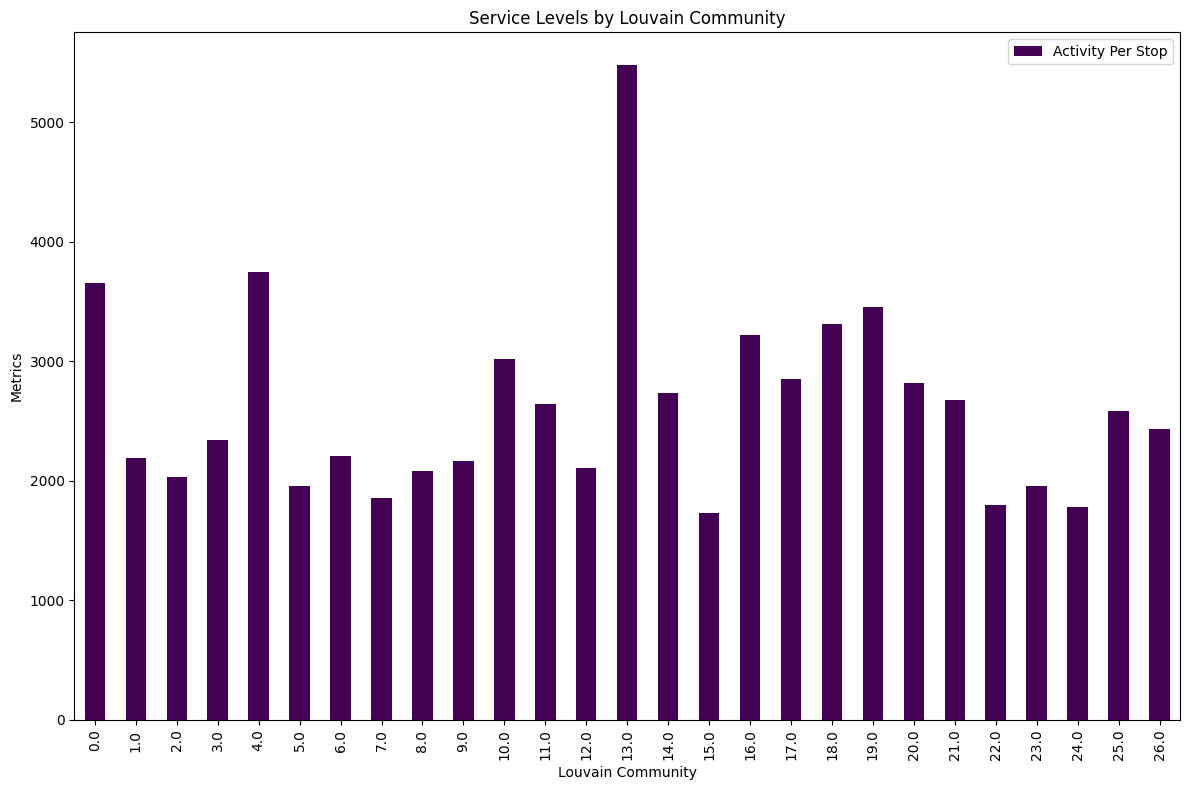

In [34]:
# Visualize the metrics
fig, ax = plt.subplots(figsize=(12, 8))
service_summary[["Activity Per Stop"]].plot(
    kind="bar", ax=ax, colormap="viridis"
)
plt.title("Service Levels by Louvain Community")
plt.xlabel("Louvain Community")
plt.ylabel("Metrics")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [35]:
# Analyze patterns by Louvain community
community_analysis = louvain_temporal_data.groupby("louvain_community")["Cluster"].value_counts(normalize=True)

print("Community-level temporal clustering proportions:")
display(community_analysis)

Community-level temporal clustering proportions:


louvain_community  Cluster
0.0                1          0.989773
                   0          0.010227
1.0                1          1.000000
2.0                1          1.000000
3.0                1          0.935166
                   0          0.064834
4.0                0          0.597681
                   1          0.402319
5.0                1          1.000000
6.0                1          1.000000
7.0                1          1.000000
8.0                1          0.961730
                   0          0.038270
9.0                1          1.000000
10.0               1          1.000000
11.0               1          1.000000
12.0               1          0.979736
                   0          0.020264
13.0               0          0.941621
                   1          0.058379
14.0               1          0.921971
                   0          0.078029
15.0               1          0.829583
                   0          0.170417
16.0               1          0.68454

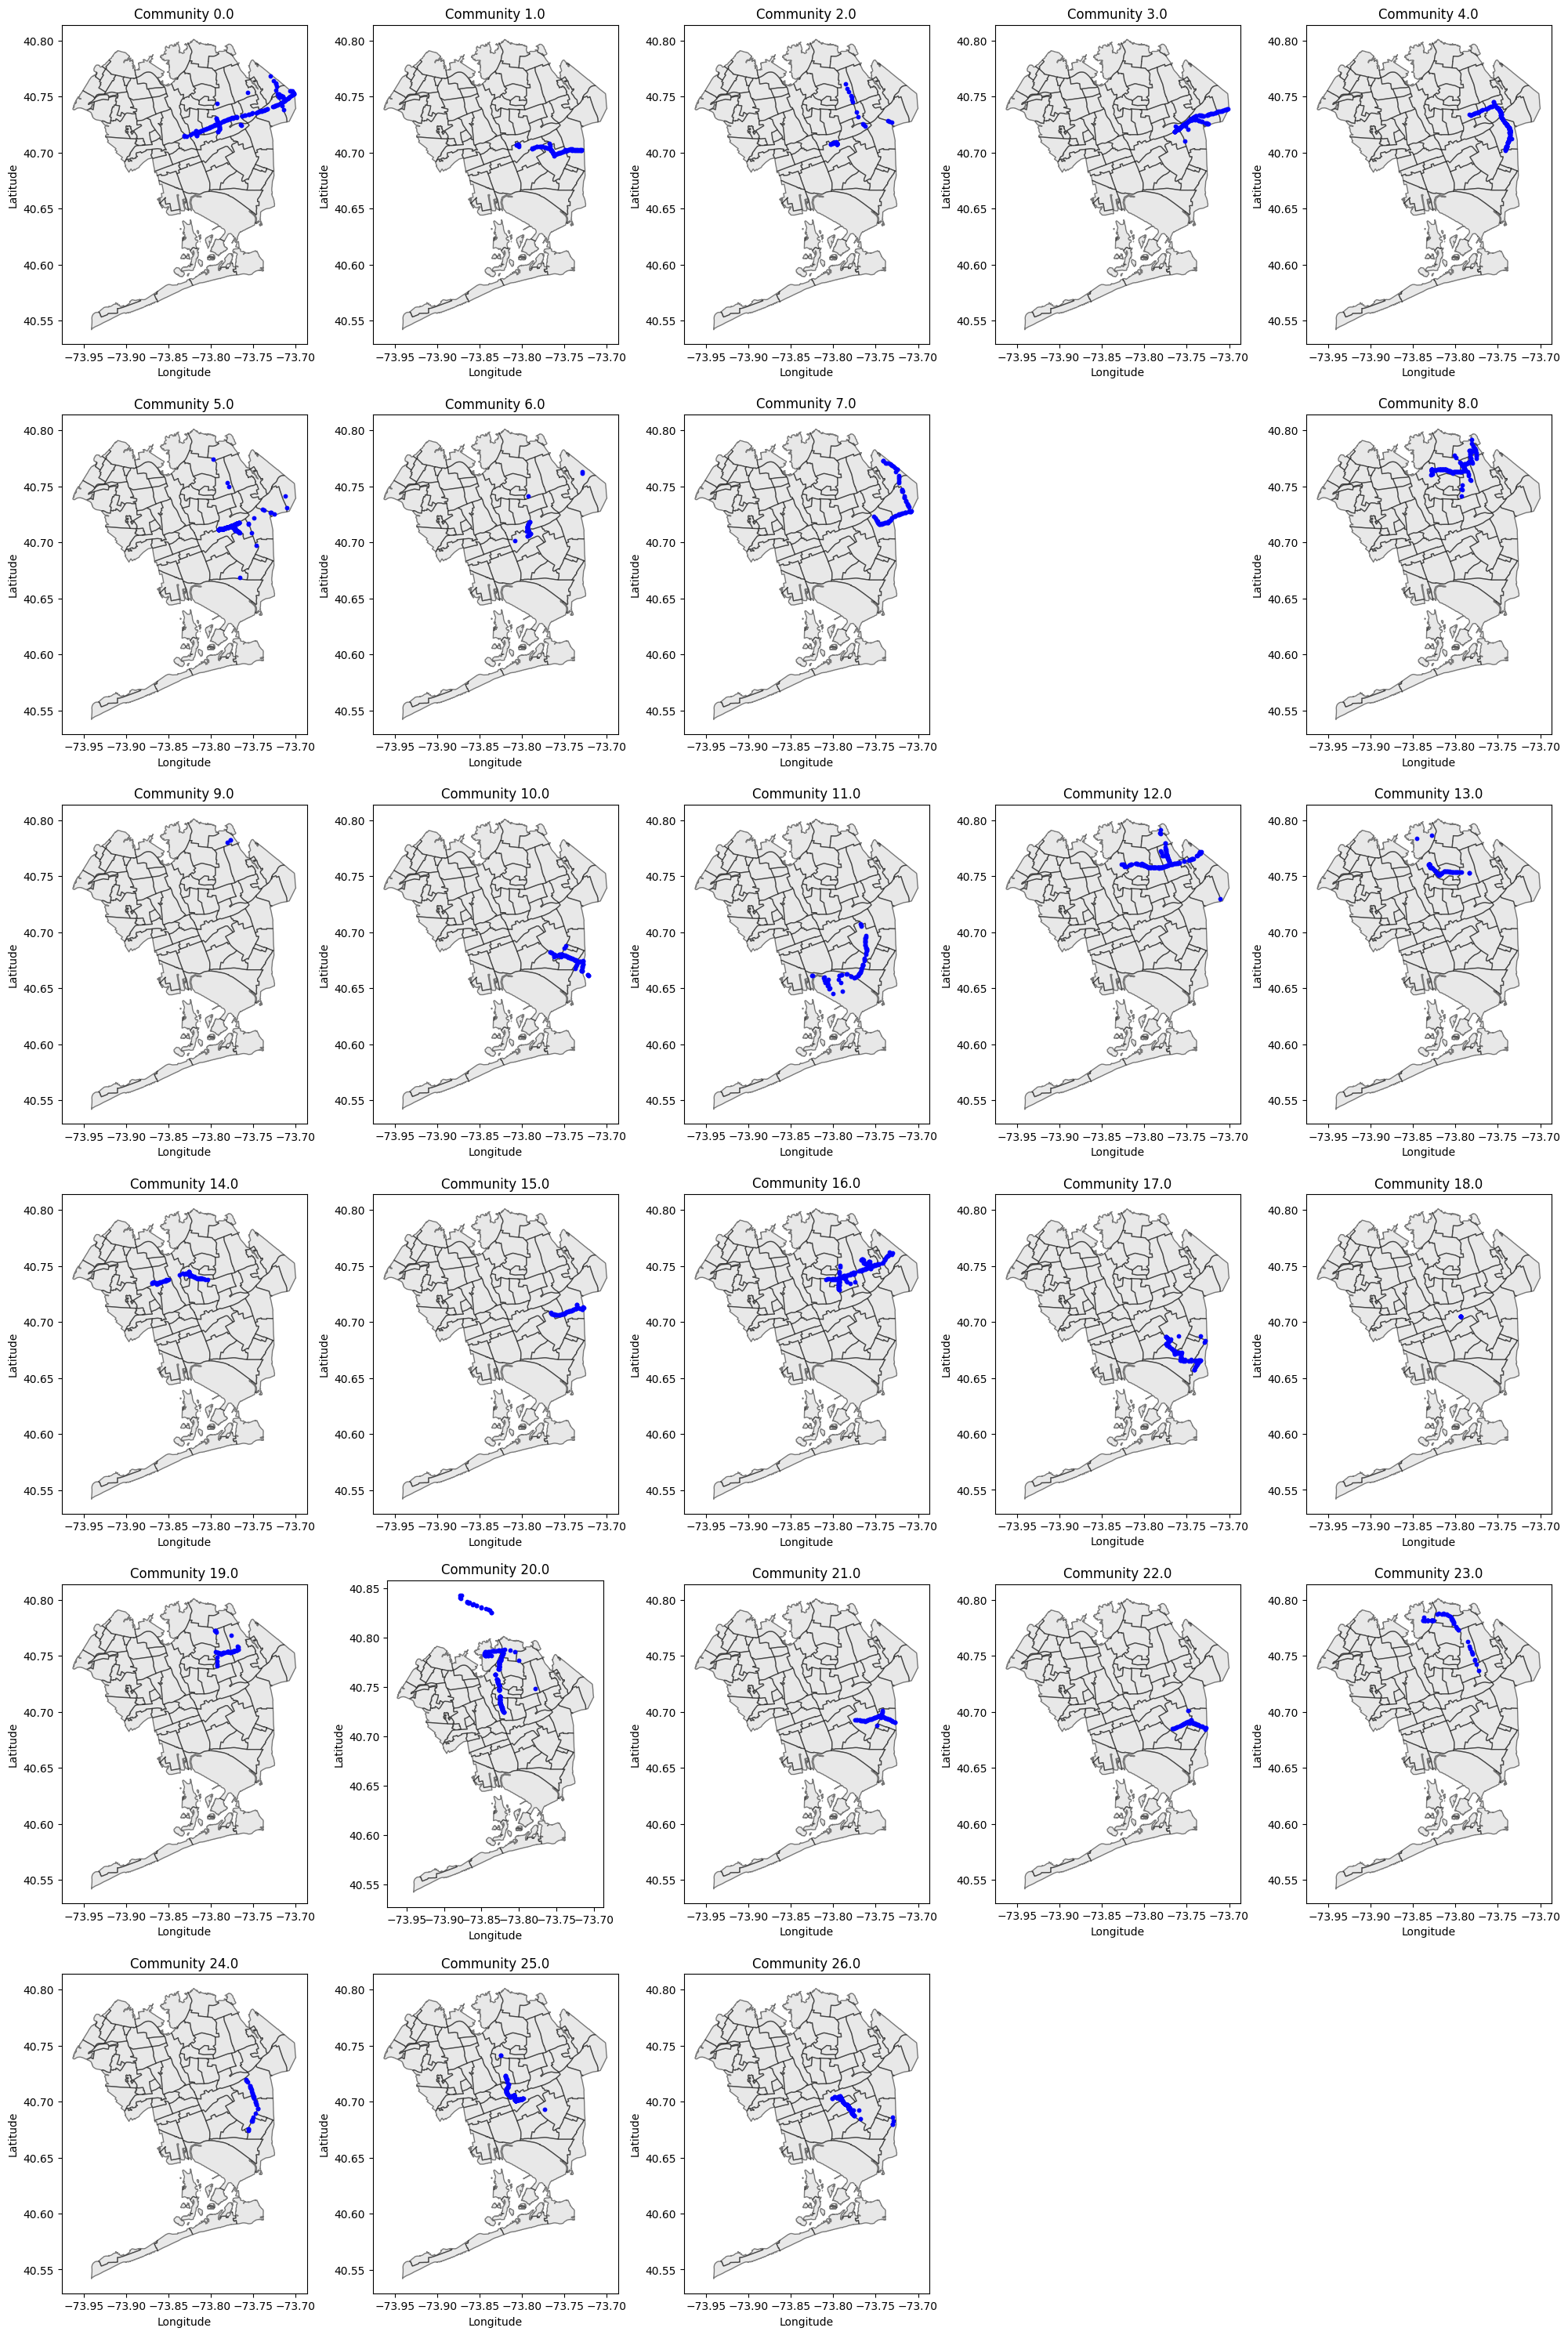

In [36]:
# Visualize temporal patterns for all Louvain clusters in a grid of subplots
# Get unique communities and dynamically calculate grid dimensions
unique_communities = sorted(louvain_temporal_data["louvain_community"].unique())
num_communities = len(unique_communities)
grid_rows = int(np.ceil(num_communities / 5))  # At most 4 columns per row
grid_cols = min(5, num_communities)           # No more than 4 columns

fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(20, grid_rows * 5))
axes = axes.flatten()  # Ensure 1D indexing

for idx, community_id in enumerate(unique_communities):
    # Avoid indexing errors
    if idx >= len(axes):
        break

    ax = axes[idx]

    # Filter stops for the current community
    community_stops = stops_gdf[stops_gdf["louvain_community"] == community_id]

    # Check if community_stops is non-empty
    if community_stops.empty:
        ax.axis("off")
        continue

    # Aggregate temporal activity for the community
    temporal_data = combined_data[combined_data["Route"].isin(community_stops["route_id"])]
    hourly_activity = temporal_data.groupby(temporal_data.index.hour).size()

    # Plot map
    queens_map.plot(ax=ax, color="lightgrey", edgecolor="black", alpha=0.5)
    community_stops.plot(ax=ax, color="blue", markersize=10)

    # Customize subplot
    ax.set_title(f"Community {community_id}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

# Turn off unused axes
for idx in range(num_communities, len(axes)):
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

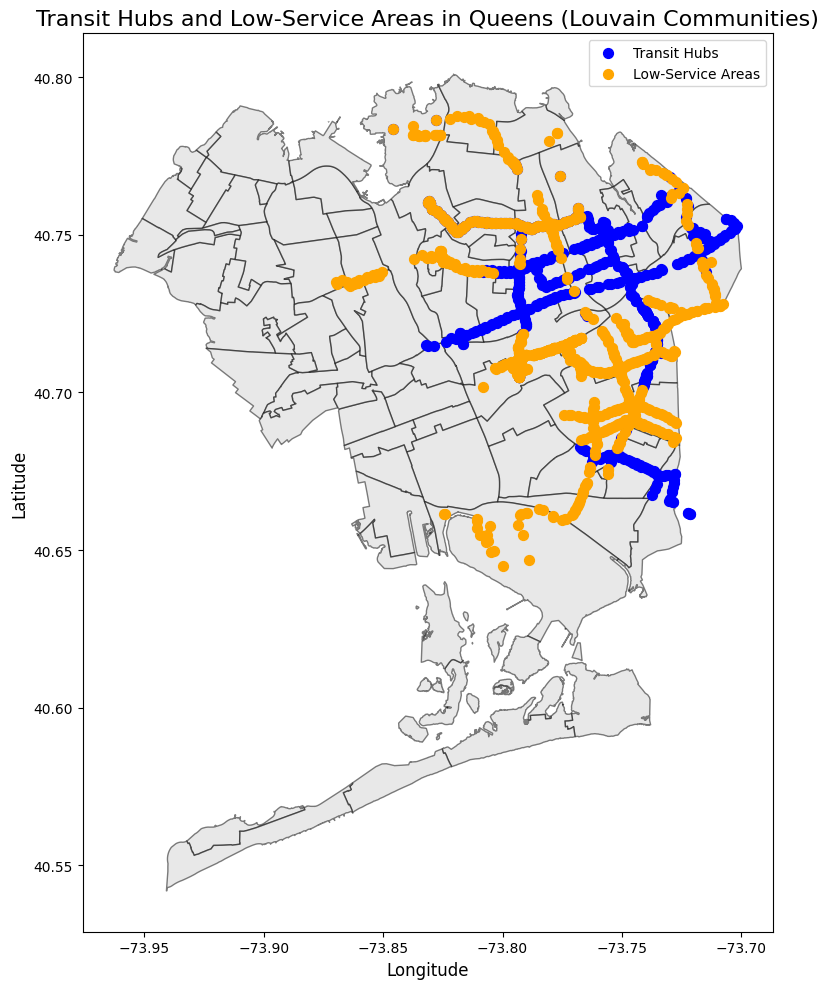

In [37]:
# Define thresholds for hubs and low-service areas
hub_threshold = service_summary["Activity Per Stop"].quantile(0.75)
low_service_threshold = service_summary["Activity Per Stop"].quantile(0.25)

# Identify transit hubs
transit_hubs = service_summary[
    (service_summary["Activity Per Stop"] >= hub_threshold) &
    (service_summary["Average Temporal Activity"] >= service_summary["Average Temporal Activity"].median())
]

# Identify low-service areas
low_service_areas = service_summary[
    (service_summary["Activity Per Stop"] <= low_service_threshold) |
    (service_summary["Number of Stops"] < service_summary["Number of Stops"].median())
]

# Plot the map
fig, ax = plt.subplots(figsize=(12, 10))
queens_map.plot(ax=ax, color="lightgrey", edgecolor="black", alpha=0.5)

# Ensure valid geometries for hubs and low-service areas
hubs_gdf = stops_gdf[stops_gdf["louvain_community"].isin(transit_hubs.index)]
low_service_gdf = stops_gdf[stops_gdf["louvain_community"].isin(low_service_areas.index)]

# Filter out invalid or empty geometries
hubs_gdf = hubs_gdf[~hubs_gdf.geometry.is_empty & hubs_gdf.geometry.is_valid]
low_service_gdf = low_service_gdf[~low_service_gdf.geometry.is_empty & low_service_gdf.geometry.is_valid]

# Check if there are any valid data points for plotting
if hubs_gdf.empty and low_service_gdf.empty:
    print("No valid data points for hubs or low-service areas to plot.")

# Ensure valid geometries for hubs and low-service areas
hubs_gdf = hubs_gdf[(~hubs_gdf.geometry.is_empty) & (hubs_gdf.geometry.is_valid)]
low_service_gdf = low_service_gdf[(~low_service_gdf.geometry.is_empty) & (low_service_gdf.geometry.is_valid)]

# Plot transit hubs
if not hubs_gdf.empty:
    hubs_gdf.plot(ax=ax, color="blue", markersize=50, label="Transit Hubs")

# Plot low-service areas
if not low_service_gdf.empty:
    low_service_gdf.plot(ax=ax, color="orange", markersize=50, label="Low-Service Areas")

# Customize plot
plt.title("Transit Hubs and Low-Service Areas in Queens (Louvain Communities)", fontsize=16)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.legend(loc="upper right", fontsize=10)
plt.tight_layout()
plt.savefig('../images/hubs_and_lsas_eastern_queens.png', dpi = 300)
plt.show()

In [38]:
# Removed redundant plotting code that followed the grid of subplots. Visualization for all Louvain clusters is handled within the grid implementation.
for community_id in louvain_temporal_data["louvain_community"].unique():
    community_data = louvain_temporal_data[louvain_temporal_data["louvain_community"] == community_id]
    print(f"Louvain Community {community_id} Temporal Cluster Distribution:")
    print(community_data["Cluster"].value_counts())

Louvain Community 2.0 Temporal Cluster Distribution:
Cluster
1    81289
Name: count, dtype: int64
Louvain Community 5.0 Temporal Cluster Distribution:
Cluster
1    304844
Name: count, dtype: int64
Louvain Community 3.0 Temporal Cluster Distribution:
Cluster
1    267419
0     18540
Name: count, dtype: int64
Louvain Community 4.0 Temporal Cluster Distribution:
Cluster
0    309000
1    207998
Name: count, dtype: int64
Louvain Community 7.0 Temporal Cluster Distribution:
Cluster
1    142926
Name: count, dtype: int64
Louvain Community 6.0 Temporal Cluster Distribution:
Cluster
1    101649
Name: count, dtype: int64
Louvain Community nan Temporal Cluster Distribution:
Series([], Name: count, dtype: int64)
Louvain Community 15.0 Temporal Cluster Distribution:
Cluster
1    60168
0    12360
Name: count, dtype: int64
Louvain Community 11.0 Temporal Cluster Distribution:
Cluster
1    171470
Name: count, dtype: int64
Louvain Community 17.0 Temporal Cluster Distribution:
Cluster
1    265428
Name: co

In [39]:
# Merge real-time data with stops_gdf to include vehicle_id
merged_data = stops_gdf.merge(
    real_time_data,
    on=["stop_id", "route_id"],
    how="left"
)
merged_data.dtypes

route_id                     object
stop_id                      object
stop_name                    object
stop_lat                    float64
stop_lon                    float64
coords                       object
geometry                   geometry
index_right                 float64
shape_area                   object
ntaname                      object
cdtaname                     object
shape_leng                   object
boroname                     object
ntatype                      object
nta2020                      object
borocode                     object
countyfips                   object
ntaabbrev                    object
cdta2020                     object
hdbscan_cluster               int64
louvain_community           float64
vehicle_id                   object
vehicle_lat                 float64
vehicle_lon                 float64
timestamp            datetime64[ns]
nearest_stop_id              object
distance_to_stop            float64
Time Gap                    

In [40]:
merged_data

route_id     stop_id                          stop_name   stop_lat  \
0       MTA NYCT_Q1  MTA_500002                 165 ST/HILLSIDE AV  40.709146   
1       MTA NYCT_Q1  MTA_500002                 165 ST/HILLSIDE AV  40.709146   
2       MTA NYCT_Q1  MTA_500002                 165 ST/HILLSIDE AV  40.709146   
3       MTA NYCT_Q1  MTA_500002                 165 ST/HILLSIDE AV  40.709146   
4       MTA NYCT_Q1  MTA_500002                 165 ST/HILLSIDE AV  40.709146   
...             ...         ...                                ...        ...   
51496  MTA NYCT_Q88  MTA_904089  HORACE HARDING EXPWY/KISSENA BLVD  40.738504   
51497  MTA NYCT_Q88  MTA_904089  HORACE HARDING EXPWY/KISSENA BLVD  40.738504   
51498  MTA NYCT_Q88  MTA_904089  HORACE HARDING EXPWY/KISSENA BLVD  40.738504   
51499  MTA NYCT_Q88  MTA_904089  HORACE HARDING EXPWY/KISSENA BLVD  40.738504   
51500  MTA NYCT_Q88  MTA_904089  HORACE HARDING EXPWY/KISSENA BLVD  40.738504   

        stop_lon                   coords                    geometry  \
0     -73.797156  (40.709146, -73.797156)  POINT (-73.79716 40.70915)   
1     -73.797156  (40.709146, -73.797156)  POINT (-73.79716 40.70915)   
2     -73.797156  (40.709146, -73.797156)  POINT (-73.79716 40.70915)   
3     -73.797156  (40.709146, -73.797156)  POINT (-73.79716 40.70915)   
4     -73.797156  (40.709146, -73.797156)  POINT (-73.79716 40.70915)   
...          ...                      ...                         ...   
51496 -73.814423  (40.738504, -73.814423)   POINT (-73.81442 40.7385)   
51497 -73.814423  (40.738504, -73.814423)   POINT (-73.81442 40.7385)   
51498 -73.814423  (40.738504, -73.814423)   POINT (-73.81442 40.7385)   
51499 -73.814423  (40.738504, -73.814423)   POINT (-73.81442 40.7385)   
51500 -73.814423  (40.738504, -73.814423)   POINT (-73.81442 40.7385)   

       index_right     shape_area                         ntaname  ...  \
0            215.0  46824594.0674                         Jamaica  ...   
1            215.0  46824594.0674                         Jamaica  ...   
2            215.0  46824594.0674                         Jamaica  ...   
3            215.0  46824594.0674                         Jamaica  ...   
4            215.0  46824594.0674                         Jamaica  ...   
...            ...            ...                             ...  ...   
51496        195.0  36974156.4783  Pomonok-Electchester-Hillcrest  ...   
51497        195.0  36974156.4783  Pomonok-Electchester-Hillcrest  ...   
51498        195.0  36974156.4783  Pomonok-Electchester-Hillcrest  ...   
51499        195.0  36974156.4783  Pomonok-Electchester-Hillcrest  ...   
51500        195.0  36974156.4783  Pomonok-Electchester-Hillcrest  ...   

      cdta2020 hdbscan_cluster louvain_community     vehicle_id vehicle_lat  \
0         QN12               0               2.0  MTA NYCT_8024   40.709159   
1         QN12               0               2.0  MTA NYCT_8030   40.708998   
2         QN12               0               2.0  MTA NYCT_8030   40.708998   
3         QN12               0               2.0  MTA NYCT_8103   40.708861   
4         QN12               0               2.0  MTA NYCT_8296   40.708454   
...        ...             ...               ...            ...         ...   
51496     QN08              -1              14.0  MTA NYCT_8613   40.738592   
51497     QN08              -1              14.0  MTA NYCT_8648   40.739029   
51498     QN08              -1              14.0  MTA NYCT_8799   40.738515   
51499     QN08              -1              14.0  MTA NYCT_8821   40.738582   
51500     QN08              -1              14.0  MTA NYCT_8841   40.738592   

      vehicle_lon                  timestamp nearest_stop_id distance_to_stop  \
0      -73.797244 2025-01-14 10:18:02.568403      MTA_500002         0.009891   
1      -73.797143 2025-01-11 22:26:32.504246      MTA_500002         0.016520   
2      -73.797143 2025-01-11 22:26:42.252483      MTA_500002         0.016520   

In [41]:
# Neighborhood Analysis
# Aggregate metrics by neighborhood and include Louvain communities
service_summary = merged_data.groupby("ntaname").agg({
    "louvain_community": lambda x: list(set(x.dropna())),
    "stop_id": "count",  # Total stop count
    "vehicle_id": "count",  # Total bus activity count
}).rename(columns={"stop_id": "Stop Count", "vehicle_id": "Bus Activity Count"})

# Reset index to retain neighborhood_name as a column
service_summary.reset_index(inplace=True)

# Calculate Activity-to-Stop Ratio
service_summary["Activity-to-Stop Ratio"] = service_summary["Bus Activity Count"] / service_summary["Stop Count"]

# Merge service_summary into queens_map
neighborhood_analysis = queens_map.merge(service_summary, on="ntaname", how="left")

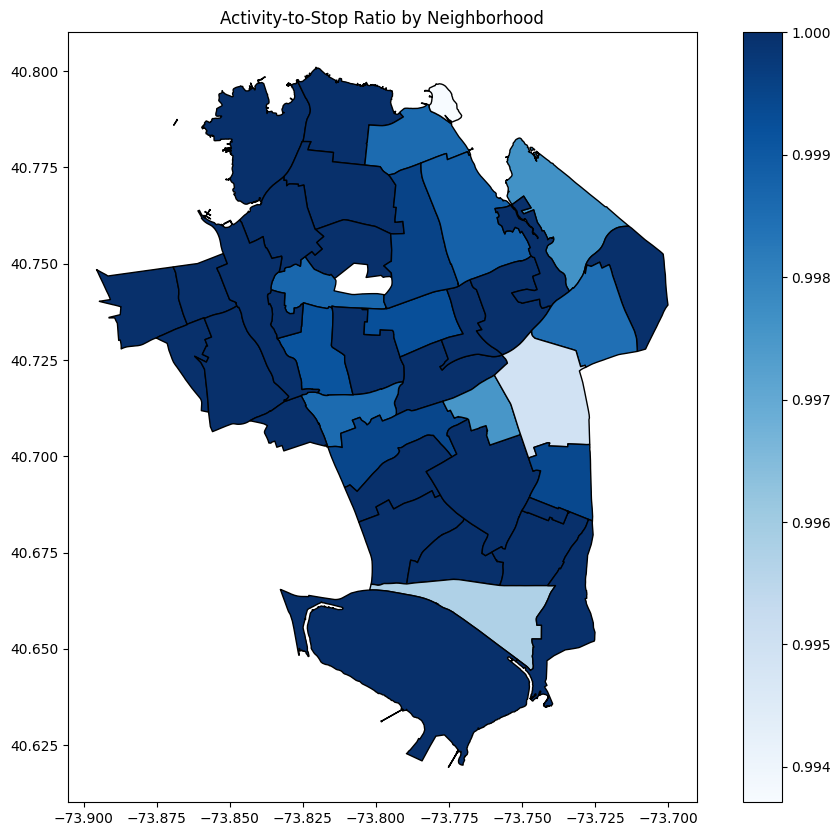

Top 10 Underserved Areas by Activity-to-Stop Ratio:


ntaname  \
16                             Fort Totten   
32                          Queens Village   
38  Springfield Gardens (South)-Brookville   
19                                  Hollis   
10                  Douglaston-Little Neck   
5                                Bellerose   
3                    Bay Terrace-Clearview   
22                 Jamaica Hills-Briarwood   
33                         Queensboro Hill   
4                                  Bayside   

                             louvain_community  Stop Count  \
16                                 [8.0, 12.0]         159   
32  [1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 15.0, 24.0]        3544   
38                                [17.0, 11.0]         469   
19                [3.0, 5.0, 11.0, 15.0, 24.0]        1215   
10                 [0.0, 6.0, 7.0, 12.0, 16.0]         847   
5               [0.0, 2.0, 3.0, 4.0, 5.0, 7.0]        1310   
3                 [8.0, 9.0, 12.0, 20.0, 23.0]         699   
22                       [0.0, 25.0, 2.0, 6.0]         701   
33                    [16.0, 25.0, 20.0, 14.0]         742   
4                 [0.0, 8.0, 12.0, 16.0, 19.0]        2534   

    Bus Activity Count  Activity-to-Stop Ratio  
16                 158                0.993711  
32                3526                0.994921  
38                 467                0.995736  
19                1212                0.997531  
10                 845                0.997639  
5                 1308                0.998473  
3                  698                0.998569  
22                 700                0.998573  
33                 741                0.998652  
4                 2531                0.998816

In [42]:
# Heatmap of neighborhoods by Activity-to-Stop Ratio
fig, ax = plt.subplots(figsize=(12, 10))
neighborhood_analysis.plot(
    column="Activity-to-Stop Ratio",
    cmap="Blues",
    legend=True,
    ax=ax,
    edgecolor="black"
)
plt.title("Activity-to-Stop Ratio by Neighborhood")
plt.savefig("../images/activity_to_stop_ratio_heatmap.png", dpi=300)
plt.show()

# Display key statistics table for underserved areas
underserved_areas = service_summary.sort_values("Activity-to-Stop Ratio").head(10)
print("Top 10 Underserved Areas by Activity-to-Stop Ratio:")
display(underserved_areas)


## Experimental Code
Code beyond this pount is inconsquential to the project for completion. Beyond this point lies attempts to properly export information for the Streamlit app, DBSCAN, and PageRank algorithms.

In [54]:
stops_gdf.columns

Index(['route_id', 'stop_id', 'stop_name', 'stop_lat', 'stop_lon', 'coords',
       'geometry', 'index_right', 'shape_area', 'ntaname', 'cdtaname',
       'shape_leng', 'boroname', 'ntatype', 'nta2020', 'borocode',
       'countyfips', 'ntaabbrev', 'cdta2020', 'hdbscan_cluster',
       'louvain_community'],
      dtype='object')

In [53]:
# Save route labels
with open(f"{data_directory}route_labels.pkl", "wb") as f:
    pickle.dump(route_labels, f)
print("Route clustering labels saved.")
# Save service summary to pickle
with open(f"{data_directory}service_summary.pkl", "wb") as f:
    pickle.dump(service_summary, f)
print("Neighborhood-level service summary saved.")
with open(f"{data_directory}neighborhood_analysis.pkl", "wb") as f:
    pickle.dump(neighborhood_analysis, f)
print("Neighborhood analysis saved.")
with open(f"{data_directory}real_time_data.pkl", "wb") as f:
    pickle.dump(real_time_data, f)
print("Real-Time Data saved")

# File paths for saving outputs
hdbscan_clusters_csv = f"{data_directory}hdbscan_clusters.csv"
hdbscan_summary_json = f"{data_directory}hdbscan_summary.json"
hdbscan_visualization_png = "../images/hdbscan_clusters_map.png"
hdbscan_visualization_pickle = f"{data_directory}hdbscan_figure.pkl"

louvain_communities_csv = f"{data_directory}louvain_communities.csv"
louvain_summary_json = f"{data_directory}louvain_summary.json"
louvain_visualization_png = "../images/louvain_network_map.png"
louvain_visualization_pickle = f"{data_directory}louvain_figure.pkl"

# --- HDBSCAN Outputs ---
# 1. Save cluster assignments to a CSV
stops_gdf[["stop_id", "hdbscan_cluster"]].to_csv(hdbscan_clusters_csv, index=False)
print(f"HDBSCAN cluster assignments saved to {hdbscan_clusters_csv}.")

# 2. Save cluster summary to JSON
hdbscan_summary = stops_data["hdbscan_cluster"].value_counts().to_dict()
with open(hdbscan_summary_json, "w") as f:
    json.dump(hdbscan_summary, f, indent=4)
print(f"HDBSCAN cluster summary saved to {hdbscan_summary_json}.")

# 3. Save cluster visualization
hdbscan_fig, ax = plt.subplots(figsize=(12, 8))
visualize_clusters(
    stops_gdf,
    cluster_col="hdbscan_cluster",
    title="Best HDBSCAN Clusters Overlaid on Queens Neighborhoods",
    map_data=queens_map
)
plt.savefig(hdbscan_visualization_png, dpi=300)
print(f"HDBSCAN cluster visualization saved to {hdbscan_visualization_png}.")

# Save the figure object as a pickle file
with open(hdbscan_visualization_pickle, "wb") as f:
    pickle.dump(hdbscan_fig, f)
print(f"HDBSCAN cluster visualization figure saved to {hdbscan_visualization_pickle}.")

# --- Louvain Outputs ---
# 1. Save community assignments to a CSV
stops_gdf[["stop_id", "louvain_community"]].to_csv(louvain_communities_csv, index=False)
print(f"Louvain community assignments saved to {louvain_communities_csv}.")

# 2. Save community summary to JSON
louvain_summary = Counter(partition.values())
with open(louvain_summary_json, "w") as f:
    json.dump(dict(louvain_summary), f, indent=4)
print(f"Louvain community summary saved to {louvain_summary_json}.")

# 3. Save network visualization
louvain_fig, ax = plt.subplots(figsize=(12, 10))
queens_map.plot(ax=ax, color="lightgrey", edgecolor="black", alpha=0.5)
for community_id in sorted(partition.values()):
    community_stops = stops_gdf[stops_gdf["louvain_community"] == community_id]
    community_stops.plot(ax=ax, label=f"Community {community_id}", markersize=10, alpha=0.7)

plt.title("Louvain Communities with Geographic Overlay", fontsize=16)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.legend(loc="upper right", fontsize=10)
plt.tight_layout()
plt.savefig(louvain_visualization_png, dpi=300)
print(f"Louvain network visualization saved to {louvain_visualization_png}.")

# Save the figure object as a pickle file
with open(louvain_visualization_pickle, "wb") as f:
    pickle.dump(louvain_fig, f)
print(f"Louvain network visualization figure saved to {louvain_visualization_pickle}.")

Route clustering labels saved.
Neighborhood-level service summary saved.
Neighborhood analysis saved.
Real-Time Data saved
HDBSCAN cluster assignments saved to ../data/hdbscan_clusters.csv.


KeyError: 'hdbscan_cluster'

## DBSCAN

In [72]:
# Step 1: Run DBSCAN
eps = 0.00005  # Adjust based on your data
min_samples = 5
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric="haversine")
stops_gdf["cluster"] = dbscan.fit_predict(np.radians(stops_gdf[["stop_lat", "stop_lon"]]))

In [73]:
# Step 2: Save and Visualize Clusters
stops_gdf.to_csv(f"{data_directory}dbscan_clusters.csv", index=False)
print("DBSCAN Cluster Counts:")
print(stops_gdf["cluster"].value_counts())

DBSCAN Cluster Counts:
cluster
 0    1996
 2     141
-1      74
 4      42
 6      18
 5      17
 1       8
 3       4
Name: count, dtype: int64


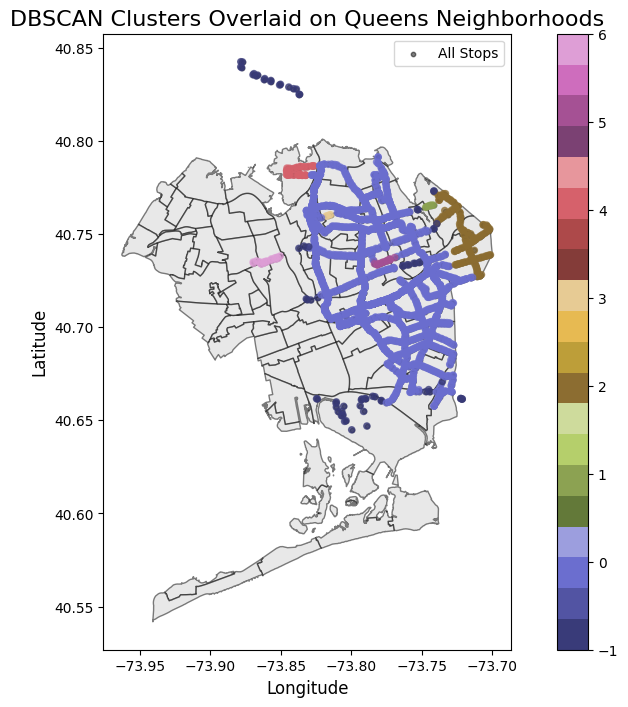

In [74]:
# Visualize DBSCAN Clusters with the Queens map
visualize_clusters(
    stops_gdf, 
    cluster_col="cluster", 
    title="DBSCAN Clusters Overlaid on Queens Neighborhoods", 
    map_data=queens_map
)

## PageRank
PageRank was developed by Google to rank webpages by importance, using the number of links leading to them as a proxy. It has since been generalized to apply to any directed graph. Modeling bus stops in this way should allow us to identify areas of high and low density, just as clustering would, but without machine learning.

In [ ]:
# Step 1: Construct Edges Based on Proximity
distance_threshold = 0.1  # in kilometers (500 meters)
edges = []

print("Constructing edges for PageRank...")
for stop1, stop2 in tqdm(combinations(stops_gdf["stop_id"], 2), desc="Computing edges"):
    coord1 = stops_gdf.loc[stops_gdf["stop_id"] == stop1, "coords"].values[0]
    coord2 = stops_gdf.loc[stops_gdf["stop_id"] == stop2, "coords"].values[0]
    if geodesic(coord1, coord2).kilometers <= distance_threshold:
        edges.append((stop1, stop2))

In [ ]:
# Step 2: Create a Directed Graph
G = nx.DiGraph()

# Add nodes
for _, row in stops_gdf.iterrows():
    G.add_node(row["stop_id"], latitude=row["stop_lat"], longitude=row["stop_lon"])

# Add edges
G.add_edges_from(edges)

In [ ]:
# Step 3: Compute PageRank
pagerank_scores = nx.pagerank(G, alpha=0.85)
stops_gdf["pagerank"] = stops_gdf["stop_id"].map(pagerank_scores)

# Step 4: Save and Visualize PageRank Results
stops_gdf.to_csv(f"{data_directory}pagerank_results.csv", index=False)
print("Top 10 Bus Stops by PageRank:")
print(stops_gdf.sort_values("pagerank", ascending=False).head(10))

In [ ]:
# Visualize PageRank Scores with the Queens map
visualize_clusters(
    stops_gdf, 
    cluster_col="pagerank", 
    title="PageRank Scores Overlaid on Queens Neighborhoods", 
    map_data=queens_map
)